# Summary of this notebook

1. Edit the images labeled as 1 or -1 for a certain attribute to the opposite direction, i.e. if an image is labeled as 1 (e.g. bald) we will edit it in the opposite direction -1 (with hair) using the SVM vectors computed on the training dataset.
2. Classify the edited images using the same discriminator that was used on the training dataset, in order to determine whether the edit was successful.
3. Metrics:
* The first metric we use is an accuracy based on a threshold on the scores given by the classifier. The threshold was determined qualitatively by looking at pictures with different scores.
* The second metric is simply the average score (after applying a sigmoid to the scores).



As the goal is to compare the results of InterFaceGAN with those of GANSpace, we have to find attributes for which we can edit with both methods.

Here are some that we found:  
Benchmarking was performed on the following attributes:
* gender (CelebA attribute number: 20 (scale_factor = 2), component from PCA: 0) (label = 1 if male)
* bald (CelebA attribute number: 4 (scale_factor = 1), component from PCA: 21 (layers 2-4, scale_factor = 50)) (label = 1 if bald)
* smiling (CelebA attribute number: 31 (scale_factor = 1), component from PCA: 23 (layers 3-5, scale_factor = 11)) (label = 1 if smiling)

We also found the following common attributes, but did not perform benchmarking on them:
* hair color blond (CelebA attributes: 9 for blond, 11 for brown, PCA component 10 (layers 7-8))
* hair color brown (CelebA attribute 11, PCA component 10 (layers 7-8))
* gray hair (CelebA attribute 17, PCA component 57 (layers 7-9))
* mouth slightly open (CelebA attribute 21, PCA component 35)

Update torchvision to fix checksum mismatch (see https://github.com/pytorch/vision/issues/7744)

In [1]:
%pip install -U torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.8/209.8 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━

Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Install StyleGAN2-ada-pytorch dependencies

In [3]:
# This pip install avoids warnings.
!pip install click requests tqdm pyspng ninja imageio-ffmpeg==0.4.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 205.9/205.9 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 37.4 MB/s eta 0:00:00
  Attempting uninstall: imageio-ffmpeg
    Found existing installation: imageio-ffmpeg 0.4.9
    Uninstalling imageio-ffmpeg-0.4.9:
      Successfully uninstalled imageio-ffmpeg-0.4.9


In [6]:
import json
import torch, pickle
import functools

from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt

import numpy as np
from tqdm import tqdm


# Retrieving StyleGAN2

In order to edit the images, we need the StyleGAN2 model.
This notebook assumes that stylegan2-ada-pytorch and the FFHQ pretrained weights are present in your Google Drive. If this is not the case, go to Part 1 of ImageGenerator.ipynb to download them.

cd to YOUR PATH TO stylegan2-ada-pytorch

Gurvan's path: /content/drive/MyDrive/UNIVERSITE/MVAmaterials/Projet_IIN/InterFaceGAN/stylegan2-ada-pytorch

Victor's path: /content/drive/MyDrive/Projet_IIN/InterFaceGAN/stylegan2-ada-pytorch

In [4]:
%cd /content/drive/MyDrive/UNIVERSITE/MVAmaterials/Projet_IIN/InterFaceGAN/stylegan2-ada-pytorch

/content/drive/MyDrive/UNIVERSITE/MVAmaterials/Projet_IIN/InterFaceGAN/stylegan2-ada-pytorch


In [7]:
# Retrieving Generator
device_name = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device_name)

with open('ffhq.pkl', 'rb') as f:
    G = pickle.load(f)['G_ema'].to(device)  # torch.nn.Module
if device_name == "cpu":
  G.synthesis.forward = functools.partial(G.synthesis.forward, force_fp32=True)

In [ ]:
%cd /content/drive/MyDrive/UNIVERSITE/MVAmaterials/Projet_IIN/InterFaceGAN

/content/drive/MyDrive/UNIVERSITE/MVAmaterials/Projet_IIN/InterFaceGAN


# Loading labeled latent vectors from test_dataset

**Adjust to your setup:** Paths to labels JSON file and archive containing latent vectors

In [8]:
attribute_number = 31
Victor = False

if Victor:
  latent_vectors_path = '/content/drive/MyDrive/Projet_IIN/InterFaceGAN/test_dataset/test_ImageLatentCodes.tar.gz'
  labels_path = f'/content/drive/MyDrive/Projet_IIN/InterFaceGAN/test_dataset/Labels/att{str(attribute_number)}_labels.json'
else :
  latent_vectors_path = '/content/drive/MyDrive/UNIVERSITE/MVAmaterials/Projet_IIN/InterFaceGAN/test_dataset/test_ImageLatentCodes.tar.gz'
  labels_path = f'/content/drive/MyDrive/UNIVERSITE/MVAmaterials/Projet_IIN/InterFaceGAN/test_dataset/Labels/att{str(attribute_number)}_labels.json'


In [9]:
%cd /content
!tar zxvf {latent_vectors_path}

Streaming output truncated to the last 5000 lines.
test_ImageLatentCodes/tensor4000.pt
test_ImageLatentCodes/tensor4001.pt
test_ImageLatentCodes/tensor4002.pt
test_ImageLatentCodes/tensor4003.pt
test_ImageLatentCodes/tensor4004.pt
test_ImageLatentCodes/tensor4005.pt
test_ImageLatentCodes/tensor4006.pt
test_ImageLatentCodes/tensor4007.pt
test_ImageLatentCodes/tensor4008.pt
test_ImageLatentCodes/tensor4009.pt
test_ImageLatentCodes/tensor4010.pt
test_ImageLatentCodes/tensor4011.pt
test_ImageLatentCodes/tensor4012.pt
test_ImageLatentCodes/tensor4013.pt
test_ImageLatentCodes/tensor4014.pt
test_ImageLatentCodes/tensor4015.pt
test_ImageLatentCodes/tensor4016.pt
test_ImageLatentCodes/tensor4017.pt
test_ImageLatentCodes/tensor4018.pt
test_ImageLatentCodes/tensor4019.pt
test_ImageLatentCodes/tensor4020.pt
test_ImageLatentCodes/tensor4021.pt
test_ImageLatentCodes/tensor4022.pt
test_ImageLatentCodes/tensor4023.pt
test_ImageLatentCodes/tensor4024.pt
test_ImageLatentCodes/tensor4025.pt
test_ImageLat

In [10]:
# Load the labels
with open(labels_path, 'r') as f:
  labels_dict = json.load(f)

num_samples = len(labels_dict)
dim = 512
Z = torch.zeros((num_samples, dim)).to(device)
y = np.zeros(num_samples, dtype=int)

for i, (filename, label) in tqdm(enumerate(labels_dict.items())):
  sample_number = int(filename[3:-4])
  tensor_path = f'/content/test_ImageLatentCodes/tensor{sample_number}.pt'
  Z[i] = torch.load(tensor_path, map_location=device)
  y[i] = label

400it [00:00, 2353.87it/s]


In [11]:
# Creating vectors in W

W = G.mapping(Z, None)

Setting up PyTorch plugin "bias_act_plugin"... Done.


# Grouping tensors by label


In [12]:
# Sorting Z latent vectors
class_1_tensors_Z = []
class_2_tensors_Z = []

for tensor, label in zip(Z, y) :
  if label == 1 : class_1_tensors_Z.append(tensor)
  elif label == -1 : class_2_tensors_Z.append(tensor)

#print(f"{len(class_1_tensors_Z)} + {len(class_2_tensors_Z)}, {len(Z)}")

assert len(class_1_tensors_Z) + len(class_2_tensors_Z) == len(Z), f"{len(class_1_tensors_Z)} + {len(class_2_tensors_Z)}, {len(Z)}"

# Converting to tensors

class_1_tensors_Z =  torch.stack(class_1_tensors_Z, dim=1)
class_2_tensors_Z =  torch.stack(class_2_tensors_Z)

# Sorting W latent vectors
class_1_tensors_W = []
class_2_tensors_W = []

for tensor, label in zip(W,y) :
  if label == 1 : class_1_tensors_W.append(tensor)
  elif label == -1 : class_2_tensors_W.append(tensor)

# Converting to tensors

class_1_tensors_W = torch.stack(class_1_tensors_W)
class_2_tensors_W = torch.stack(class_2_tensors_W)

# Editing with InterFaceGAN (in $\mathcal{W}$)




## Retrieving vectors from SVM computed on the train_dataset

In [13]:
if Victor:
  SVM_vectors_path = f'/content/drive/MyDrive/Projet_IIN/InterFaceGAN/SVM_vectors/'
else :
  SVM_vectors_path = '/content/drive/MyDrive/UNIVERSITE/MVAmaterials/Projet_IIN/InterFaceGAN/SVM_vectors/'


In [14]:
class_direction_Z = torch.load( SVM_vectors_path + f'class_direction_Z_on_3k_att{attribute_number}.pt').to(device)
Z_intercept = torch.load( SVM_vectors_path + f'Z_intercept_on_3k_att{attribute_number}.pt').to(device)

class_direction_W = torch.load( SVM_vectors_path + f'class_direction_W_on_3k_att{attribute_number}.pt').to(device)
W_intercept = torch.load( SVM_vectors_path + f'W_intercept_on_3k_att{attribute_number}.pt').to(device)

In [15]:
def IFGAN_AllLayersEdition_NoPlot(tensors_for_edition, direction, class_direction, b, G, save_path=None, scale_factor = 1.):
  """
  Edition of images by editing in the latent space Z with InteFaceGAN method,
  i.e. by going in the opposite direction from the orthogonal vector of the hyperplane that separates class_1 and class_2 tensors.

  z: latent vectors
  direction: going to the class -1 or to the class 1
  class_direction: orthogonal vector of the hyperplane made by a linear svm on the data.
  b: corresponds to the attribute intercept_ of the hyperplane, i.e. the position of the hyperplane.
  G: Generator network of StyleGAN2.
  scale_factor: Scale the power of the changes.

  returns: torch.Tensor shaped (batch_size, channel, height, width)

  """
  Img = torch.zeros(tensors_for_edition.shape[0], 3, 1024, 1024)

  norm = torch.norm(class_direction)

  if direction == -1 :
    dir = 'minus1'
  else :
    dir = '1'

  for k, tensor in enumerate(tensors_for_edition) :

      tensor_transformed = tensor.clone()
      distance = -(torch.dot(class_direction, tensor[0]) +b)/norm**2 # Moves the tensor onto the hyperplane.

      tensor_transformed += class_direction*distance + scale_factor*class_direction*direction
      tensor_transformed = tensor_transformed.to(device)

      img = 255*((0.5 * (G.synthesis(tensor_transformed[None, :, :])[0] + 1)).clip(0,1)) # [None, :, :] because synthesis needs shape (batch, 18, 512)
      Img[k] = img
      if save_path is not None :
        assert len(tensors_for_edition) < 5, " You are trying to put a lot of files in a Drive folder, it is not recommended."
        plt.imsave(save_path + f'att_{attribute_number}_dir_{dir}_img{k}.jpg', (img/255).cpu().detach().numpy().transpose((1,2,0)))

  return Img


All-layers editing :

In [ ]:
%ls

drive/  sample_data/  test_ImageLatentCodes/


In [ ]:
save_path_GANS = '/content/drive/MyDrive/UNIVERSITE/MVAmaterials/Projet_IIN/InterFaceGAN/test_dataset/GANs_edited_test_images/'

In [16]:
IFGAN_Img1 = IFGAN_AllLayersEdition_NoPlot(class_1_tensors_W, -1, class_direction_W, W_intercept, G, scale_factor=1.)
IFGAN_Img2 = IFGAN_AllLayersEdition_NoPlot(class_2_tensors_W, 1, class_direction_W, W_intercept, G, scale_factor=1.)

#torch.save(IFGAN_Img1, save_path_GANS + f'IFGAN_Img1_att{attribute_number}' )
#torch.save(IFGAN_Img2, save_path_GANS + f'IFGAN_Img2_att{attribute_number}' )

Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


In [ ]:
%cd /content/drive/MyDrive/UNIVERSITE/MVAmaterials/Projet_IIN/InterFaceGAN/test_dataset/GANs_edited_test_images/

# Editing with GANSpace (in $\mathcal{W}$)

In [ ]:
# Retrieving vectors from PCA computed on the train_dataset (in GANSpace.ipynb)
V = torch.load('/content/drive/MyDrive/UNIVERSITE/MVAmaterials/Projet_IIN/InterFaceGAN/PCA_vectors/W_PCA_on_100000_points.pt')

In [ ]:
def GANSpace_LayerWiseEdition_NoPLot(tensors_for_edition, direction, V, G, comp: int, layer_group: list = None, save_path=None, scale_factor = 1.):
  """
  Do a layer-wise change along the vector number "comp" of the V basis from PCA.

  layer_groups : Default corresponds to groups of Figure 3 of StyleGAN paper (2019)
  i.e. Core styles (layers 1-4); Middle styles (5-9); Fine styles (10-18)
  """

  Img = torch.zeros(tensors_for_edition.shape[0], 3, 1024, 1024)

  if direction == -1 :
    dir = 'minus1'
  else :
    dir = '1'

  for k, tensor in enumerate(tensors_for_edition) :

      tensor_transformed = tensor.clone()
      tensor_transformed[layer_group, :] += direction * scale_factor * V[comp]
      tensor_transformed = tensor_transformed.to(device)

      img = 255*((0.5 * (G.synthesis(tensor_transformed[None, :, :])[0] + 1)).clip(0,1)) # [None, :, :] because synthesis needs shape (batch, 18, 512)
      Img[k] = img
      if save_path is not None :
        assert len(tensors_for_edition) < 5
        plt.imsave(save_path + f'att_{attribute_number}_dir_{dir}_img{k}.jpg', (img/255).cpu().detach().numpy().transpose((1,2,0)))

  return Img

In [17]:
def IFGANAll_Edition(tensors_for_edition, direction, class_direction, b, G, n_steps_var = 7, save_path=None, scale_factor = 1.):
  """
  Edit images with given latent vectors along given direction using InterFaceGAN and plot the results.
  """

  n_plot = len(tensors_for_edition)

  steps = torch.linspace(0.0, 1.0, n_steps_var)*scale_factor

  norm = torch.norm(class_direction)

  fig = plt.figure(figsize=(2*n_steps_var, 2*n_plot))
  grid = ImageGrid(fig, 111, nrows_ncols=(n_plot, n_steps_var), axes_pad=0.3, label_mode='all')

  for i, tensor in enumerate(tensors_for_edition):
    for istep in range(n_steps_var):
        tensor_transformed = tensor.clone()
        distance = -(torch.dot(class_direction, tensor[0]) +b)/norm**2 # Moves the tensor onto the hyperplane.

        tensor_transformed += class_direction*distance + steps[istep]*class_direction*direction
        tensor_transformed = tensor_transformed.to(device)

        img = 255*((0.5 * (G.synthesis(tensor_transformed[None, :, :])[0] + 1)).clip(0,1)) # [None, :, :] because synthesis needs shape (batch, 18, 512)
        score = classify(img[None, :], device)[:, attribute_number].sigmoid()
        iplot = i * n_steps_var + istep

        if istep==0 :
          grid[iplot].set_ylabel(f"$\\mathrm{{IFG}}(\mathbf{{v}}_{{ att = {attribute_number}}}, \\mathrm{{all}})$", rotation = 0, size = 'x-large')
          grid[iplot].yaxis.set_label_coords(-0.5,0.45)

        grid[iplot].set_xlabel(f' score = {score.cpu().item():.4f}')
        grid[iplot].imshow(img.permute((1, 2, 0)).cpu().numpy().astype(int))
        grid[iplot].set_yticklabels([])
        grid[iplot].set_xticklabels([])
        grid[iplot].set_xticks([])
        grid[iplot].set_yticks([])



  plt.show()

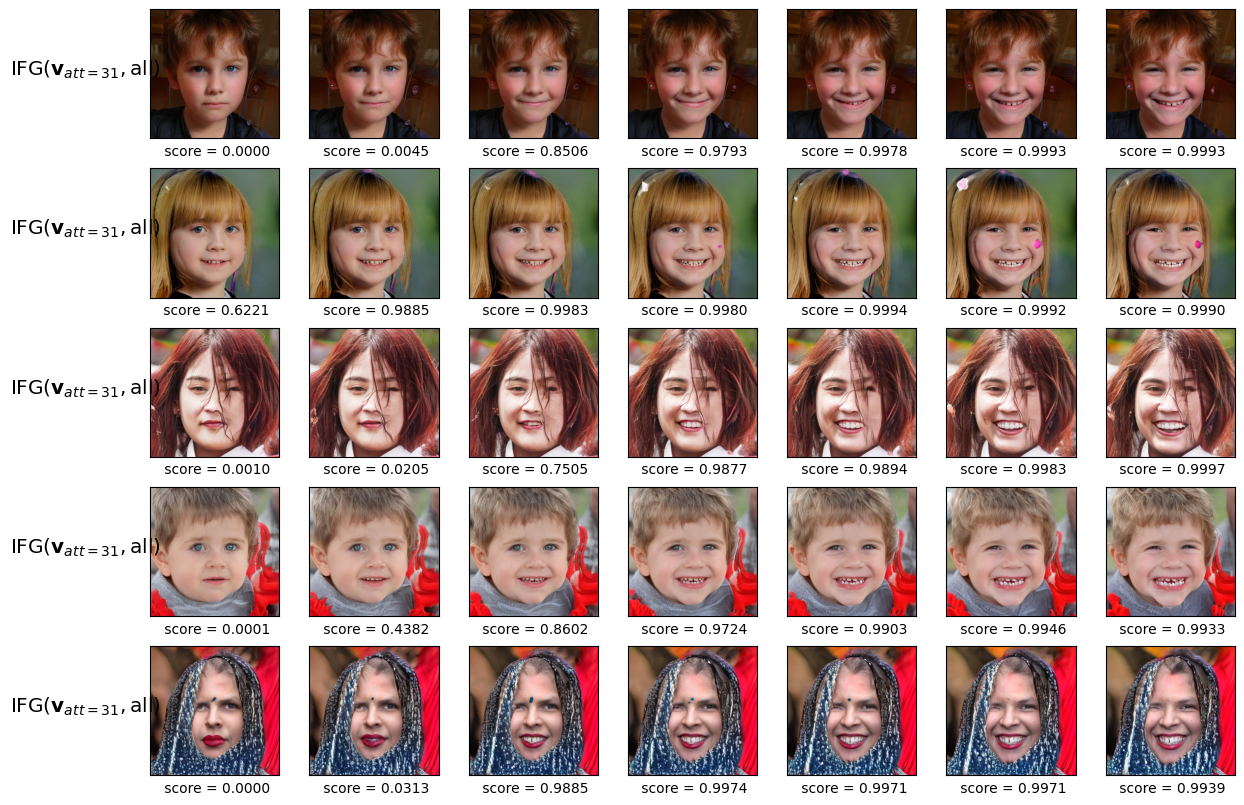

In [26]:
IFGANAll_Edition(class_2_tensors_W[20:25], 1, class_direction_W, W_intercept, G, n_steps_var = 7, scale_factor = 1.)

In [ ]:
GANSpace_Img1 = GANSpace_LayerWiseEdition_NoPLot(class_1_tensors_W, -1, V, G, comp = 0, layer_group = list(range(18)), scale_factor = -3.)
GANSpace_Img2 = GANSpace_LayerWiseEdition_NoPLot(class_2_tensors_W, 1, V, G, comp = 0, layer_group = list(range(18)), scale_factor = -3.)

#torch.save(GANSpace_Img1, save_path_GANS + f'GANSpace_Img1_att{attribute_number}' )
#torch.save(GANSpace_Img2, save_path_GANS + f'GANSpace_Img2_att{attribute_number}' )

In [ ]:
def layer_group_to_string(group):
  if len(group) >= 2 and list(group) == list(range(min(group), max(group)+1)):
    return f"{min(group)}-{max(group)}"
  else:
    return "\\{" + (",".join(map(str, group))) + "\\}"

def LayerWiseEdition(V, G, w, comps: list = None, layer_groups: list = None, n_steps_var = 7, N_sigma=2., save=False):
  """
  Do a layer-wise change along the vector number "comp" of the V basis from PCA.

  layer_groups : Default corresponds to groups of Figure 3 of StyleGAN paper (2019)
  i.e. Core styles (layers 1-4); Middle styles (5-9); Fine styles (10-18)
  """
  d = G.z_dim
  if comps is None:
    comps = [1, 10, 2]
  if layer_groups is None :
    layer_groups = [[0, 1, 2, 3], [4, 5, 6, 7], [8, 9, 10, 11, 12, 13, 14, 15, 16, 17]]

  n_plot = len(layer_groups)

  steps = torch.linspace(0.0, 1.0, n_steps_var)*N_sigma

  fig = plt.figure(figsize=(2*n_steps_var, 2*n_plot))
  grid = ImageGrid(fig, 111, nrows_ncols=(n_plot, n_steps_var), axes_pad=0.1)

  for i, group in enumerate(layer_groups):
    comp = comps[i]
    for istep in range(n_steps_var):
        w_transformed = w.clone()
        w_transformed[group, :] += steps[istep] * V[comp]

        w_transformed = w_transformed.to(device)
        img = G.synthesis(w_transformed[None, :,:]).cpu().detach().numpy()[0].transpose((1, 2, 0))
        img = 255 * (img + 1) / 2
        img = np.clip(img.astype(int), 0, 255)
        score = classify(torch.Tensor([img.transpose((2, 0, 1))]), device)[:, attribute_number].sigmoid()
        iplot = i * n_steps_var + istep

        if istep==0 :
          grid[iplot].set_ylabel(f"$\\mathrm{{E}}(\mathbf{{v}}_{{{comp}}}, {layer_group_to_string(group)})$", rotation = 0, size = 'x-large')
          grid[iplot].yaxis.set_label_coords(-0.5,0.45)

        grid[iplot].imshow(img)
        grid[iplot].set_yticklabels([])
        grid[iplot].set_xticklabels([])
        grid[iplot].set_xticks([])
        grid[iplot].set_yticks([])
        grid[iplot].set_xlabel(f' score = {score.cpu().item():.4f}')


  plt.show()
  if save:
    fig.savefig("layerwise.pdf")

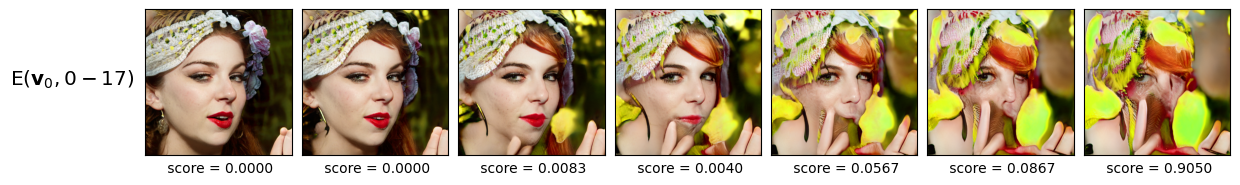

In [ ]:
LayerWiseEdition(V, G, class_2_tensors_W[35], comps = [0], layer_groups = [list(range(18))], n_steps_var = 7, N_sigma=-3., save=False)

# Classifying edited images


In [19]:
%cd /content/drive/MyDrive/UNIVERSITE/MVAmaterials/Projet_IIN/

/content/drive/MyDrive/UNIVERSITE/MVAmaterials/Projet_IIN


We have determined the following success thresholds manually (by looking at images with their scores):

| Attribute    | Direction | Logit<br> threshold | Threshold after<br> sigmoid |
|--------------|-----------|---------------------|-----------------------------|
| 4 (bald)     | -1 to 1   | 0.5                 | 0.62                        |
| 4 (bald)     | 1 to -1   | -4.0                | 0.018                       |
| 31 (smiling) | -1 to 1   | 1.0                 | 0.73                        |
| 31 (smiling) | 1 to -1   | -4.2                | 0.015                       |
| 20 (male)    | -1 to 1   | 3.0                 | 0.95                        |
| 20 (male)    | 1 to -1   | -2.0                | 0.12                        |

In [20]:
threshold_map = {(4, 1) : 0.62, (4, -1) : 0.018, (20, 1) : 0.95, (20, -1): 0.12, (31, 1): 0.73, (31, -1): 0.015 }

Computation of classification scores and edit success rate ("accuracy").  
See discriminator.py for code of classify (mainly an adaptation of ImageDiscriminator.ipynb).

In [21]:
from discriminator import classify

def threshold_score(Img, direction, att_number):

  threshold = threshold_map[(att_number, direction)]
  scores = torch.zeros(Img.shape[0], device = device)
  bs = 10
  for i in range(0, len(Img), bs):
    batch = Img[i:min(i+bs, len(Img))]
    scores[i:min(i+bs, len(Img))] = classify(batch, device)[:, att_number].sigmoid()# tensor on GPU shape (batch_size, )

  if direction == 1 :
    accuracy = torch.sum(scores > threshold)/len(scores)
  else :
    accuracy = torch.sum(scores < threshold)/len(scores)

  return torch.mean(scores), torch.std(scores), accuracy

In [ ]:
print(IFGAN_Img1.shape)

torch.Size([200, 3, 1024, 1024])


Formatting results in a LaTeX table

In [24]:
from tabulate import tabulate

#IFGAN results :

headers = [f'IFGAN, attribute {attribute_number}', 'average', 'std', 'accuracy', 'threshold']
table = []

for Img, direction in zip([IFGAN_Img1, IFGAN_Img2], [-1, 1]) :
  average, std, accuracy = threshold_score(Img, direction, attribute_number)
  table.append([f'direction : {-direction} towards {direction}', f'{average:.5f}', f'{std:.4f}', f'{accuracy:.3f}', threshold_map[(attribute_number, direction)] ])

print(tabulate(table, headers, tablefmt="latex"))

\begin{tabular}{lrrrr}
\hline
 IFGAN, attribute 31      &   average &    std &   accuracy &   threshold \\
\hline
 direction : 1 towards -1 &   0.00069 & 0.0018 &      0.995 &       0.015 \\
 direction : -1 towards 1 &   0.98387 & 0.0721 &      0.975 &       0.73  \\
\hline
\end{tabular}


In [ ]:
#GANSpace results :

headers = [f'GANSpace, attribute {attribute_number}', 'average', 'std', 'accuracy', 'threshold']
table = []

for Img, direction in zip([GANSpace_Img1, GANSpace_Img2], [-1, 1]) :
  average, std, accuracy = threshold_score(Img, direction, attribute_number)
  table.append([f'direction : {-direction} towards {direction}', f'{average:.5f}', f'{std:.4f}', f'{accuracy:.3f}', threshold_map[(attribute_number, direction)] ])

print(tabulate(table, headers, tablefmt="latex"))

\begin{tabular}{lrrrr}
\hline
 GANSpace, attribute 20   &   average &    std &   accuracy &   threshold \\
\hline
 direction : 1 towards -1 &   0.15803 & 0.2508 &       0.7  &        0.12 \\
 direction : -1 towards 1 &   0.91329 & 0.2574 &       0.87 &        0.95 \\
\hline
\end{tabular}
